In [3]:
import pandas as pd
import numpy as np
import re
import recordlinkage
import pickle
import matplotlib.pyplot as plt

In [4]:
emails = pd.read_csv("compression_test.txt.gz", compression='gzip',sep = '\t')
emails = emails.fillna("")
emails = emails[['email_address', 'first_name_df', 'second_name_df']]

In [5]:
emails

,email_address,first_name_df,second_name_df
0,rating@mail.ru,,
1,xb3@mail.ru,,
2,info@aktiencheck.de,,
3,legals@heartmediact.com,,
4,8b4e078a51d04e0e9efdf470027f0ec1@sentry.wixpre...,,
...,...,...,...
2574181,hyzhenhua@mail.tzptt.zj.cn,,
2574182,hyzgkxni@gmail.com,,
2574183,hyzbhtbq@ygfqvw.com,,
2574184,hyzb@uibe.edu.cn,,


In [6]:
with open('news.pkl', 'rb') as f:
    news = pickle.load(f)
    # 3844 unique authors
    
muckrack = pd.read_csv('../Data/muckrack_persons_fetchlist.csv')

In [7]:
def first_name():
    temp = news[['author', 'article_count']].groupby('author').count().sort_values(['article_count'], ascending = False)
    temp = temp.reset_index()
    first_names = []
    author_and_outlets = []
    for i in range(len(temp)):
        first_name = temp.loc[i].author.lower()
        first_name = re.sub(r'\|.*$', '', first_name) # remove everything after |
        first_name = re.sub(r'\,.*$', '', first_name) # remove evrything after ,
        
        punctuations = '''!()[]{};:'"\,<>./?#$%^&*_~'''
        for x in first_name.lower(): 
            if x in punctuations: first_name = first_name.replace(x, "") # remove punctuations except hyphen
        first_name = re.sub(r'(\d+)', '', first_name) # remove numbers
        first_name = re.sub(r'(--)', '', first_name)
        first_name = re.sub(r'(\w+@\w+)', '', first_name) # remove emails
        first_name = ' '.join([i.strip() for i in first_name.split()]) # remove spaces and lowercase
        first_name = re.sub(r'(\s+)(and)(\s+)(\w*)(\s*)(\w*)', '', first_name) # remove anything after and
        keywords = ['sa', 'tulsa', 'editor', 'writer', 'world-herald', 'news', 'world', 'richmond', 'times-dispatch', 'new',
                   'hampshire', 'union', 'leader', 'for', 'the', 'state', 'journal', 'correspondant', 'sfgate', 'special',
                   'from', 'the', 'gazette', 'times', 'staff', 'senior', 'dr', 'correspondent', 'by', 'editorial board',
                   'research', 'wire reports', 'security', 'real', 'estate', 'to', 'post', 'and', 'courier', 'policy',
                   'commercial', 'bureau', 'political', 'roanoke', 'college', 'football', 'editorial','democrat-gazette',
                   'arizona', 'daily', 'star', '--hamburg', 'column', 'lincoln', 'managing', 'backstage', 'with', 'sports',
                   'ii', 'iii', 'capitol', 'media', 'services']
        first_name = ' '.join([i for i in first_name.split() if i not in keywords]) # remove other keywords
        first_name = re.sub(r'(@)', '', first_name) # remove handles
        first_name = first_name.split(' ')[0] # make first_name
        first_names.append(first_name)
        # get the most common outlet the person writes for
        author_and_outlets.append(f"{temp.loc[i].author} {news[news.author == temp.loc[i].author].site_name.value_counts().index[0]}")
        # print(temp.loc[i].author)
        # print(news[news.author == temp.loc[i].author].site_name.value_counts())
        # print(news[news.author == temp.loc[i].author].site_name.value_counts().index[0])
    temp['first_name_df'] = first_names
    temp['author_and_outlet'] = author_and_outlets
    return temp

In [8]:
names = first_name()

In [9]:
names

,author,article_count,first_name_df,author_and_outlet
0,Neil Shaw,523,neil,Neil Shaw WalesOnline
1,James Rodger,512,james,James Rodger BirminghamLive
2,Jack Davis,251,jack,Jack Davis The Western Journal
3,Adam Wells,223,adam,Adam Wells Bleacher Report
4,Sophie McCoid,218,sophie,Sophie McCoid Liverpool Echo
...,...,...,...,...
3833,Levi Sumagaysay,10,levi,Levi Sumagaysay MarketWatch
3834,Ben Ashford,10,ben,Ben Ashford Mail Online
3835,Craig Brown,10,craig,Craig Brown Mail Online
3836,Courtney Connley,10,courtney,Courtney Connley CNBC


In [10]:
emails

,email_address,first_name_df,second_name_df
0,rating@mail.ru,,
1,xb3@mail.ru,,
2,info@aktiencheck.de,,
3,legals@heartmediact.com,,
4,8b4e078a51d04e0e9efdf470027f0ec1@sentry.wixpre...,,
...,...,...,...
2574181,hyzhenhua@mail.tzptt.zj.cn,,
2574182,hyzgkxni@gmail.com,,
2574183,hyzbhtbq@ygfqvw.com,,
2574184,hyzb@uibe.edu.cn,,


In [11]:
indexer = recordlinkage.Index()
indexer.block('first_name_df')
candidate_links = indexer.index(names, emails)
print("candidate_links:", len(candidate_links))

candidate_links: 1334518


In [12]:
compare_cl = recordlinkage.Compare()
compare_cl.exact('first_name_df', 'first_name_df', label='first_name_df')
compare_cl.string('author_and_outlet', 'email_address', label = 'email')
features = compare_cl.compute(candidate_links, names, emails)

In [13]:
features

first_name_df     email
0    7751                 1  0.222222
     11897                1  0.222222
     28036                1  0.142857
     30146                1  0.142857
     58595                1  0.206897
...                     ...       ...
3827 1768222              1  0.000000
     1768223              1  0.064516
     1768224              1  0.000000
     1768254              1  0.074074
     1768257              1  0.074074

[1334518 rows x 2 columns]

In [14]:
features['email'].value_counts().sort_index(ascending=False)

0.846154        1
0.838710        1
0.818182        1
0.814815        2
0.809524        1
            ...  
0.021739        2
0.021277        1
0.020833        2
0.016949        1
0.000000    17071
Name: email, Length: 694, dtype: int64

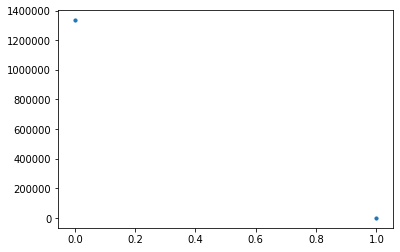

In [24]:
temp = features['email'].value_counts().sort_index(ascending=False)
plt.scatter(list(temp.index), list(temp.values), s=10)

In [25]:
compare_cl = recordlinkage.Compare()
compare_cl.exact('first_name_df', 'first_name_df', label='first_name_df')
compare_cl.string('author_and_outlet', 'email_address', label = 'email', threshold = 0.5)
features = compare_cl.compute(candidate_links, names, emails)

In [26]:
features['email'].value_counts().sort_index(ascending=False)

1.0       1899
0.0    1332619
Name: email, dtype: int64

In [27]:
names.iloc[2876], emails.iloc[260037]

(author                            Scott Murray
 article_count                               13
 first_name_df                            scott
 author_and_outlet    Scott Murray the Guardian
 Name: 2876, dtype: object,
 email_address     scott.murray@theguardian.com
 first_name_df                            scott
 second_name_df                          murray
 Name: 260037, dtype: object)

In [28]:
names.iloc[2820], emails.iloc[1064708]

(author                         Vinciane Ngomsi
 article_count                               14
 first_name_df                         vinciane
 author_and_outlet    Vinciane Ngomsi Heavy.com
 Name: 2820, dtype: object,
 email_address     vinciane.ngomsi@blavity.com
 first_name_df                        vinciane
 second_name_df                         ngomsi
 Name: 1064708, dtype: object)

In [29]:
names.iloc[3750], emails.iloc[567236]

(author                           Myra Butterworth
 article_count                                  10
 first_name_df                                myra
 author_and_outlet    Myra Butterworth Mail Online
 Name: 3750, dtype: object,
 email_address     myra.butterworth@mailonline.co.uk
 first_name_df                                  myra
 second_name_df                          butterworth
 Name: 567236, dtype: object)

In [30]:
features[features.sum(axis=1) > 1]

first_name_df  email
1    2080352              1    1.0
340  168484               1    1.0
     417283               1    1.0
600  2080294              1    1.0
     2080416              1    1.0
...                     ...    ...
3400 162277               1    1.0
     169186               1    1.0
3544 1354085              1    1.0
3681 997332               1    1.0
3750 567236               1    1.0

[1899 rows x 2 columns]